# Predicciones de jornadas de fases con AA (Aprendizaje Automático)

## Familia de algoritmos: <code>DecisionTree</code>

## Importación de las bibliotecas de AA en Python

In [1]:
import pandas as pd
import numpy as np 
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.utils import shuffle
from joblib import dump, load
from IPython.display import display, Image
from sklearn.tree import export_graphviz
import datetime
import uuid
import math
import csv
import sqlite3
import json
import sys
import matplotlib.pyplot as plt
import seaborn as sns
!conda install --yes --prefix {sys.prefix} prettytable mscorefonts pydotplus
from prettytable import PrettyTable
import pydotplus
import matplotlib.font_manager as font_manager
font_manager._rebuild()
%matplotlib inline

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.2
  latest version: 4.8.3

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - mscorefonts
    - prettytable
    - pydotplus


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    cairo-1.16.0               |    hcf35c78_1003         1.5 MB  conda-forge
    certifi-2020.6.20          |   py37hc8dfbb8_0         151 KB  conda-forge
    expat-2.2.9                |       he1b5a44_2         191 KB  conda-forge
    fontconfig-2.13.1          |    h86ecdb6_1001         340 KB  conda-forge
    fribidi-1.0.9              |       h516909a_0         113 KB  conda-forge
    gettext-0.19.8.1           |    hc5be6a0_1002        

## Helper functions

In [2]:
def get_standard_value(scaler_max, scaled_value, phase_number):
    
    
    def min_phase_val(i):
        switcher = {
                1: 0.75,
                2: 1.5,
                3: 2,
                4: 0.25
             }
        return switcher.get(i,f"Invalid phase:{i}")


    val_to_round = scaled_value * scaler_max
    rounded_val = round((float(val_to_round)*4))/4
    if rounded_val > 0 and rounded_val > min_phase_val(phase_number):
        return rounded_val
             
    return min_phase_val(phase_number)

## Cargar los datos para entreñar y testar el modelo de AA

In [3]:
# load the csv data sets
csv_dataset = pd.read_csv("train/train-offers-dataset.csv")

# print the first few rows to make sure that data has been loaded as expected
csv_dataset.head()

,greenfield,vpc,subnets,connectivity,peerings,directoryservice,otherservices,advsecurity,advlogging,advmonitoring,...,vms,buckets,databases,elb,autoscripts,administered,phase1prediction,phase2prediction,phase3prediction,phase4prediction
0,1,1.0,0.75,0,1,1,1.0,1,0,1,...,0.8,0.0,1.0,0,1,0,3.50,5.50,5.50,3.0
1,1,1.0,0.75,0,1,1,1.0,1,0,1,...,0.8,0.0,1.0,0,1,1,3.50,5.50,5.50,3.0
2,0,0.5,0.75,0,0,0,1.0,1,1,0,...,0.6,1.0,1.0,0,1,0,3.00,4.75,4.75,2.5
3,1,0.5,0.50,0,1,0,1.0,1,0,0,...,0.0,0.0,0.5,1,1,0,1.75,2.75,2.75,1.5
4,0,0.5,0.75,0,0,0,1.0,1,1,0,...,0.6,1.0,1.0,0,1,1,3.00,4.75,4.75,2.5


## Preparar los datos de entreño-test; quitar funciones, normalizar y asignar escaladores

In [4]:
# drop featuresd with low occurance/correlation
df_train_test_base = shuffle(pd.DataFrame(csv_dataset), random_state=0)

# grab the prediction columns
df_train_test_phase1_std = df_train_test_base[['phase1prediction']].copy()
df_train_test_phase2_std = df_train_test_base[['phase2prediction']].copy()
df_train_test_phase3_std = df_train_test_base[['phase3prediction']].copy()
df_train_test_phase4_std = df_train_test_base[['phase4prediction']].copy()

# create scalers for the prediction columns
train_test_phase1_scaler = preprocessing.MinMaxScaler()
train_test_phase2_scaler = preprocessing.MinMaxScaler()
train_test_phase3_scaler = preprocessing.MinMaxScaler()
train_test_phase4_scaler = preprocessing.MinMaxScaler()

# scale the prediction columns
df_train_test_phase1_scaled = pd.DataFrame(train_test_phase1_scaler.fit_transform(df_train_test_phase1_std), columns = ['phase1prediction'])
df_train_test_phase2_scaled = pd.DataFrame(train_test_phase2_scaler.fit_transform(df_train_test_phase2_std), columns = ['phase2prediction'])
df_train_test_phase3_scaled = pd.DataFrame(train_test_phase3_scaler.fit_transform(df_train_test_phase3_std), columns = ['phase3prediction'])
df_train_test_phase4_scaled = pd.DataFrame(train_test_phase4_scaler.fit_transform(df_train_test_phase4_std), columns = ['phase4prediction'])

# normalize the dataset
mm_train_test_scaler = preprocessing.MinMaxScaler()
df_train_test_base_scaled = pd.DataFrame(mm_train_test_scaler.fit_transform(df_train_test_base), columns = ['greenfield','vpc', 'subnets', 'connectivity', 'peerings', 'directoryservice', 'otherservices', 'advsecurity', 'advlogging', 'advmonitoring', 'advbackup', 'vms', 'buckets', 'databases', 'elb', 'autoscripts', 'administered', 'phase1prediction', 'phase2prediction', 'phase3prediction', 'phase4prediction'])

df_train_test_base_scaled.head()

,greenfield,vpc,subnets,connectivity,peerings,directoryservice,otherservices,advsecurity,advlogging,advmonitoring,...,vms,buckets,databases,elb,autoscripts,administered,phase1prediction,phase2prediction,phase3prediction,phase4prediction
0,0.0,1.0,1.000000,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.8,0.0,1.0,0.0,0.0,0.0,0.259259,0.366667,0.344828,0.3750
1,0.0,1.0,1.000000,0.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.9,0.0,0.0,0.0,1.0,0.0,0.444444,0.600000,0.586207,0.6250
2,0.0,0.0,0.000000,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.9,0.0,0.0,1.0,0.0,1.0,0.296296,0.400000,0.379310,0.3750
3,0.0,1.0,1.000000,1.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.2,0.5,1.0,0.0,1.0,1.0,0.518519,0.700000,0.689655,0.6875
4,0.0,0.0,0.333333,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.9,1.0,0.0,0.0,0.0,1.0,0.185185,0.266667,0.241379,0.2500


## Cargar los datos para validar el modelo de AA

In [5]:
# load the csv data sets
csv_datavalidation = pd.read_csv("validation/validation-offers-dataset.csv")

## Preparar los datos de validación; quitar funciones, normalizar y asignar escaladores

In [6]:
# drop featuresd with low occurance/correlation
df_validation_base = pd.DataFrame(csv_datavalidation)

# grab the prediction columns
df_validation_phase1_std = df_validation_base[['phase1prediction']].copy()
df_validation_phase2_std = df_validation_base[['phase2prediction']].copy()
df_validation_phase3_std = df_validation_base[['phase3prediction']].copy()
df_validation_phase4_std = df_validation_base[['phase4prediction']].copy()

# scale the prediction columns using the training set scaling values for consitency
df_train_test_phase1_scaled = df_validation_phase1_std.apply(lambda x: x/train_test_phase1_scaler.data_max_ if x.name == 'phase1prediction' else x)
df_train_test_phase2_scaled = df_validation_phase2_std.apply(lambda x: x/train_test_phase2_scaler.data_max_ if x.name == 'phase2prediction' else x)
df_train_test_phase3_scaled = df_validation_phase3_std.apply(lambda x: x/train_test_phase3_scaler.data_max_ if x.name == 'phase3prediction' else x)
df_train_test_phase4_scaled = df_validation_phase4_std.apply(lambda x: x/train_test_phase4_scaler.data_max_ if x.name == 'phase4prediction' else x)

df_validation_base['phase1prediction'] = df_train_test_phase1_scaled
df_validation_base['phase2prediction'] = df_train_test_phase2_scaled
df_validation_base['phase3prediction'] = df_train_test_phase3_scaled
df_validation_base['phase4prediction'] = df_train_test_phase4_scaled

# normalize the dataset
df_validation_base_scaled = df_validation_base.copy()

df_validation_base_scaled.head()

,greenfield,vpc,subnets,connectivity,peerings,directoryservice,advsecurity,advlogging,advmonitoring,advbackup,...,buckets,databases,elb,autoscripts,otherservices,administered,phase1prediction,phase2prediction,phase3prediction,phase4prediction
0,1,0.5,0.75,0,0,0,0,0,0,0,...,0.5,0.5,0,0,0.2,0,0.035714,0.06250,0.12500,0.058824
1,1,0.5,0.25,0,0,0,0,0,1,0,...,0.0,0.0,0,0,0.4,0,0.035714,0.09375,0.09375,0.058824
2,1,0.5,0.50,0,0,0,0,0,0,0,...,0.5,0.0,0,0,0.6,0,0.071429,0.06250,0.12500,0.235294
3,0,0.5,0.25,1,0,0,0,0,0,0,...,0.0,0.0,0,0,0.4,0,0.071429,0.06250,0.12500,0.117647
4,1,0.5,0.50,1,0,0,0,0,0,0,...,0.5,0.5,1,0,0.0,0,0.071429,0.06250,0.06250,0.117647


## Evaluacion del modelo

In [7]:
# uuid for the evaluation run
eval_id = uuid.uuid4()

# datetime of the evaluation run
now = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

# results list
results_list = []


def score_model(phase_number, phase_name, X_train, Y_train, phase_scaler_max):
    seed = 7
    kfold = model_selection.KFold(n_splits=10, random_state=seed, shuffle=True)
    model = DecisionTreeRegressor()
    
    scoring_mae = 'neg_mean_absolute_error'
    print("Scoring model for phase {}:{} using {} ...".format(phase_number, phase_name, scoring_mae))
    result_mae = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring_mae)
    
    result_mae_inverse = get_standard_value(phase_scaler_max, result_mae.std(), phase_number)

    scoring_mse = 'neg_mean_squared_error'
    print("Scoring model for phase {}:{} using {} ...".format(phase_number, phase_name, scoring_mse))
    result_mse = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring_mse)
    
    result_mse_inverse = get_standard_value(phase_scaler_max, result_mse.std(), phase_number)

    scoring_r2 = 'r2'
    print("Scoring model for phase {}:{} using {} ...".format(phase_number, phase_name, scoring_r2))
    result_r2 = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring_r2)
    
    score_results = [eval_id,now,phase_number,phase_name,result_mse.mean(),result_mse.std(),result_mse_inverse,result_mae.mean(),result_mae.std(),result_mae_inverse,result_r2.mean(),result_r2.std()]
    results_list.append(score_results)
    

# phaseprediction test train split
df_train_test_phase1 = df_train_test_base_scaled.drop(['phase2prediction', 'phase3prediction', 'phase4prediction'], axis = 1)
df_train_test_phase2 = df_train_test_base_scaled.drop(['phase3prediction', 'phase4prediction'], axis = 1)
df_train_test_phase3 = df_train_test_base_scaled.drop(['phase4prediction'], axis = 1)
df_train_test_phase4 = df_train_test_base_scaled.copy()

phase1_x_train = df_train_test_phase1[['greenfield','vpc', 'subnets', 'connectivity', 'peerings', 'directoryservice', 'otherservices', 'advsecurity', 'advlogging', 'advmonitoring', 'advbackup', 'vms', 'buckets', 'databases', 'elb', 'autoscripts', 'administered'  ]]
phase1_y_train = df_train_test_phase1['phase1prediction']

phase2_x_train = df_train_test_phase2[['greenfield','vpc', 'subnets', 'connectivity', 'peerings', 'directoryservice', 'otherservices', 'advsecurity', 'advlogging', 'advmonitoring', 'advbackup', 'vms', 'buckets', 'databases', 'elb', 'autoscripts', 'administered', 'phase1prediction']]
phase2_y_train = df_train_test_phase2['phase2prediction']

phase3_x_train = df_train_test_phase3[['greenfield','vpc', 'subnets', 'connectivity', 'peerings', 'directoryservice', 'otherservices', 'advsecurity', 'advlogging', 'advmonitoring', 'advbackup', 'vms', 'buckets', 'databases', 'elb', 'autoscripts', 'administered', 'phase1prediction', 'phase2prediction']]
phase3_y_train = df_train_test_phase3['phase3prediction']

phase4_x_train = df_train_test_phase4[['greenfield','vpc', 'subnets', 'connectivity', 'peerings', 'directoryservice', 'otherservices', 'advsecurity', 'advlogging', 'advmonitoring', 'advbackup', 'vms', 'buckets', 'databases', 'elb', 'autoscripts', 'administered', 'phase1prediction', 'phase2prediction', 'phase3prediction']]
phase4_y_train = df_train_test_phase4['phase4prediction']

# score the models
score_model(1, "Recopilacion", phase1_x_train, phase1_y_train, train_test_phase1_scaler.data_max_)
score_model(2, "Diseno", phase2_x_train, phase2_y_train, train_test_phase2_scaler.data_max_)
score_model(3, "Implantacion", phase3_x_train, phase3_y_train, train_test_phase3_scaler.data_max_)
score_model(4, "Soporte", phase4_x_train, phase4_y_train, train_test_phase4_scaler.data_max_)

# write the text and csv results
df_score_results = pd.DataFrame(results_list, columns = ['evaluation_id','datetime','phasenumber','phasename','mse_mean','mse_std','mse_inverse','mae_mean','mae_std','mae_inverse','r2_mean','r2_std'])

with open("analysis/model/decisiontree/model-evaluation.csv", "a+") as csv_file:
    df_score_results.to_csv(csv_file, header=False, index=False)
    
df_score_results.head()

Scoring model for phase 1:Recopilacion using neg_mean_absolute_error ...
Scoring model for phase 1:Recopilacion using neg_mean_squared_error ...
Scoring model for phase 1:Recopilacion using r2 ...
Scoring model for phase 2:Diseno using neg_mean_absolute_error ...
Scoring model for phase 2:Diseno using neg_mean_squared_error ...
Scoring model for phase 2:Diseno using r2 ...
Scoring model for phase 3:Implantacion using neg_mean_absolute_error ...
Scoring model for phase 3:Implantacion using neg_mean_squared_error ...
Scoring model for phase 3:Implantacion using r2 ...
Scoring model for phase 4:Soporte using neg_mean_absolute_error ...
Scoring model for phase 4:Soporte using neg_mean_squared_error ...
Scoring model for phase 4:Soporte using r2 ...


,evaluation_id,datetime,phasenumber,phasename,mse_mean,mse_std,mse_inverse,mae_mean,mae_std,mae_inverse,r2_mean,r2_std
0,03121777-bdb6-4c2e-9656-ff548d91841c,2020-07-01 10:32:05,1,Recopilacion,-1.331534e-03,1.344524e-05,0.75,-0.008928,0.000076,0.75,0.863173,0.001185
1,03121777-bdb6-4c2e-9656-ff548d91841c,2020-07-01 10:32:05,2,Diseno,-2.487625e-04,5.667206e-06,1.50,-0.002048,0.000028,1.50,0.986608,0.000343
2,03121777-bdb6-4c2e-9656-ff548d91841c,2020-07-01 10:32:05,3,Implantacion,-1.475172e-04,5.221056e-06,2.00,-0.001096,0.000022,2.00,0.992577,0.000233
3,03121777-bdb6-4c2e-9656-ff548d91841c,2020-07-01 10:32:05,4,Soporte,-5.026952e-07,9.245995e-08,0.25,-0.000008,0.000002,0.25,0.999973,0.000006


## Visualizar el DecisionTree



#### Graficio de decision tree de fase: 1: Recopilacion ####




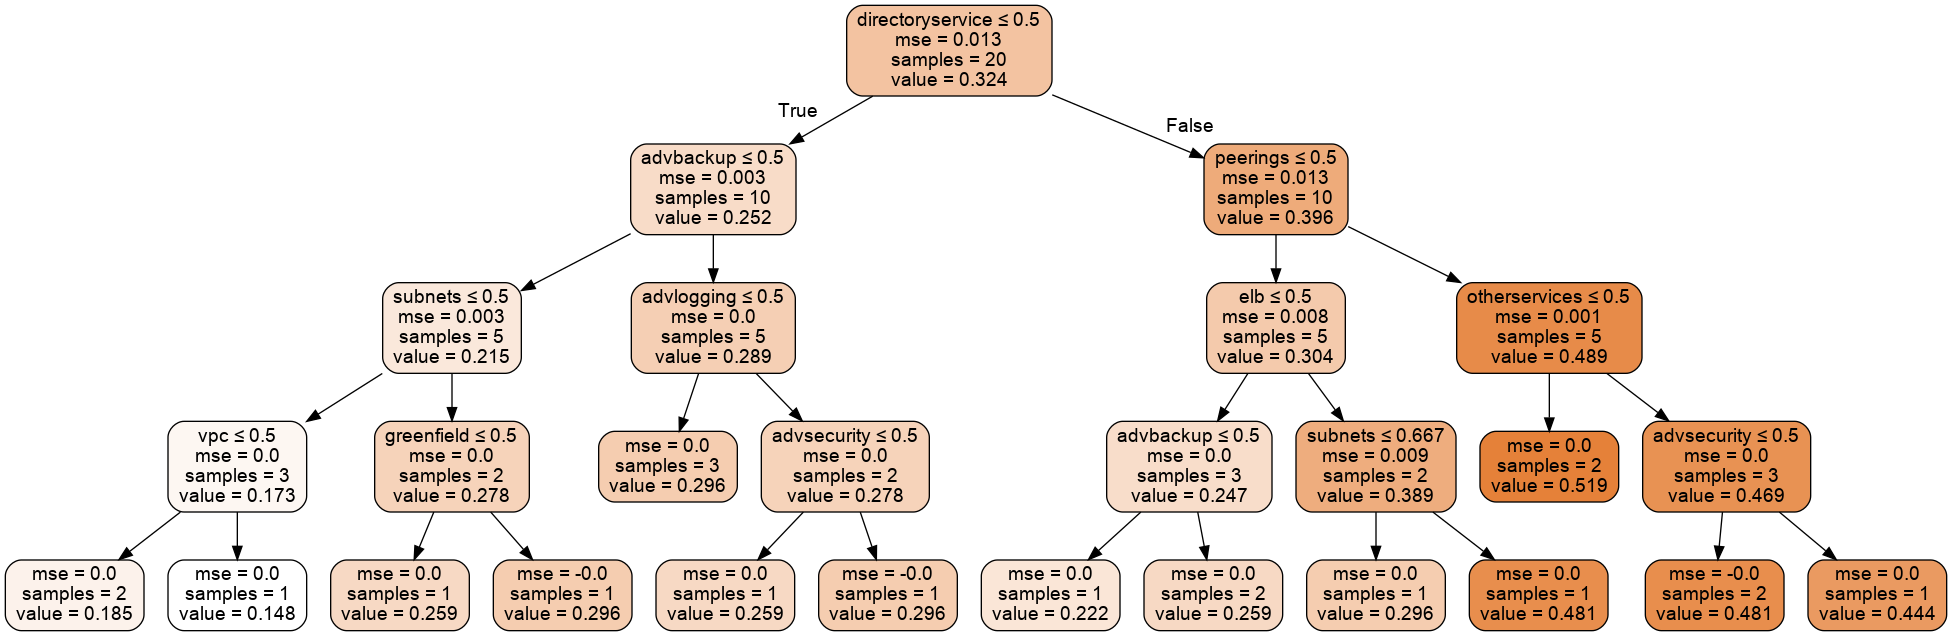



#### Graficio de decision tree de fase: 2: Diseno ####




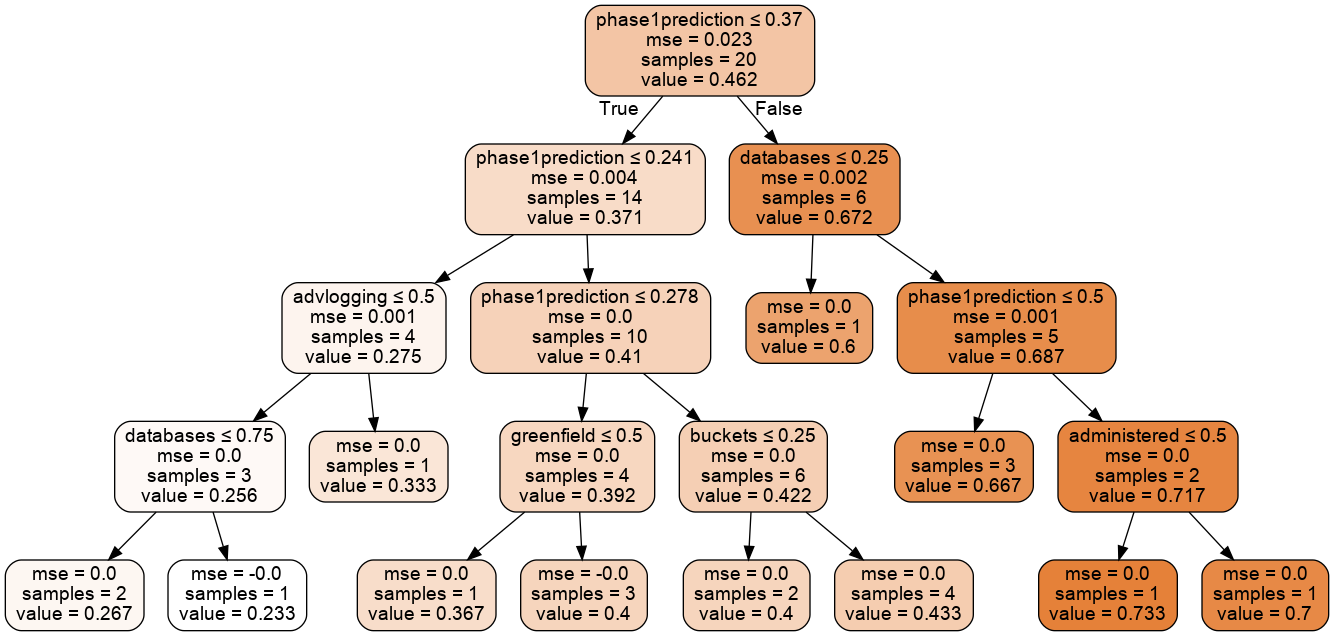



#### Graficio de decision tree de fase: 3: Implantcion ####




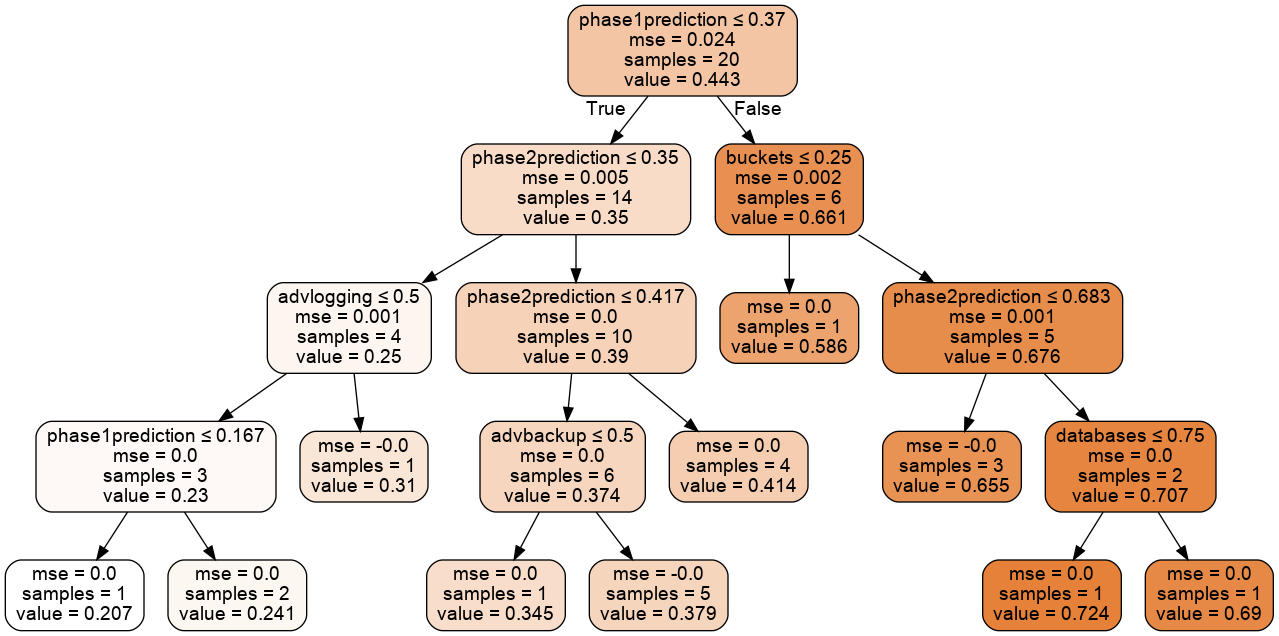



#### Graficio de decision tree de fase: 4: Soporte ####




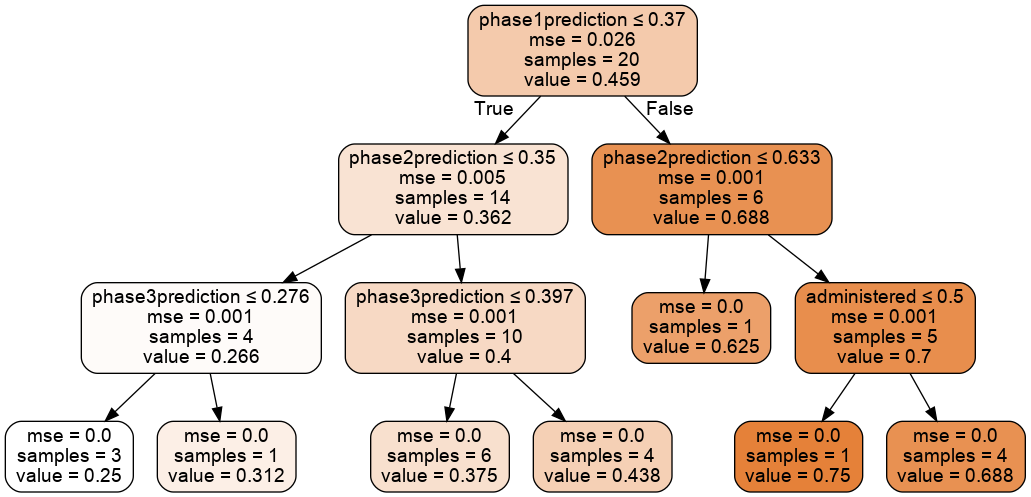

In [8]:
def render_tree(phase_number, phase_name, phase_features, X_train, Y_train):
    print("\n")
    print(f"#### Graficio de decision tree de fase: {phase_number}: {phase_name} ####")
    print("\n")
    dtree = DecisionTreeRegressor()
    dtree.fit(X_train,Y_train)
    dot_data = export_graphviz(dtree, out_file=None, 
                                        filled=True, rounded=True,
                                        feature_names = phase_features,
                                        special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data)  
    display(Image(graph.create_png()))

    
# score the models
phase1_features = ['greenfield','vpc', 'subnets', 'connectivity', 'peerings', 'directoryservice', 'otherservices', 'advsecurity', 'advlogging', 'advmonitoring', 'advbackup', 'vms', 'buckets', 'databases', 'elb', 'autoscripts', 'administered']
render_tree(1, "Recopilacion", phase1_features, phase1_x_train.head(n=20), phase1_y_train.head(n=20))

phase2_features = ['greenfield','vpc', 'subnets', 'connectivity', 'peerings', 'directoryservice', 'otherservices', 'advsecurity', 'advlogging', 'advmonitoring', 'advbackup', 'vms', 'buckets', 'databases', 'elb', 'autoscripts', 'administered', 'phase1prediction']
render_tree(2, "Diseno", phase2_features, phase2_x_train.head(n=20), phase2_y_train.head(n=20))

phase3_features = ['greenfield','vpc', 'subnets', 'connectivity', 'peerings', 'directoryservice', 'otherservices', 'advsecurity', 'advlogging', 'advmonitoring', 'advbackup', 'vms', 'buckets', 'databases', 'elb', 'autoscripts', 'administered', 'phase1prediction', 'phase2prediction']
render_tree(3, "Implantcion", phase3_features, phase3_x_train.head(n=20), phase3_y_train.head(n=20))

phase4_features = ['greenfield','vpc', 'subnets', 'connectivity', 'peerings', 'directoryservice', 'otherservices', 'advsecurity', 'advlogging', 'advmonitoring', 'advbackup', 'vms', 'buckets', 'databases', 'elb', 'autoscripts', 'administered', 'phase1prediction', 'phase2prediction', 'phase3prediction']
render_tree(4, "Soporte", phase4_features, phase4_x_train.head(n=20), phase4_y_train.head(n=20))

## Predecir las jornadas por fase con los datos de validación

In [9]:
# uuid for the evaluation run
eval_id = uuid.uuid4()

# datetime of the evaluation run
now = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

# results list
results_list = []

def predict_phases(phase_number, phase_name, scaler_max, phase_predictions, X_train, Y_train, X_validation):
    RESULT_TYPE_OVER_ESTIMATE = "SOBRE_ESTIMACION"
    RESULT_TYPE_UNDER_ESTIMATE = "SUB_ESTIMACION"
    RESULT_TYPE_EQUAL_ESTIMATE = "EQUAL_ESTIMACION"
    
    decisiontree_regression = DecisionTreeRegressor()
    
    # train and test the model
    decisiontree_regression.fit(X_train,Y_train)
    
    # dump model to disk
    dump(decisiontree_regression, f"models-saved/decisiontree/phase_{phase_number}_model.model")
    
    # get predictions based on validation data set
    predictors = decisiontree_regression.predict(X_validation)
    
    # enumerate the predictions
    for idx, j in enumerate(predictors):
        predicted_scaled = j
        actual_scaled = phase_predictions[idx]
        predicted = get_standard_value(scaler_max, predicted_scaled, phase_number)
        actual = get_standard_value(scaler_max, actual_scaled, phase_number)
        loss = 0
        percentage = 0
        result_type = RESULT_TYPE_EQUAL_ESTIMATE
        
        # OVERestimate
        if predicted > actual:
            loss = predicted - actual
            if loss > 0 and actual > 0:
                percentage = (loss/predicted)*100
            result_type = RESULT_TYPE_OVER_ESTIMATE
        # UNDERestimate
        elif actual > predicted:
            loss = actual - predicted
            if loss > 0 and actual > 0:
                percentage = ((loss/actual)*100) * -1
            
            result_type = RESULT_TYPE_UNDER_ESTIMATE

        predict_result = [eval_id, idx, now,phase_number, phase_name, actual_scaled, predicted_scaled, actual, predicted, loss, percentage, result_type]
        results_list.append(predict_result)
            

# phaseprediction test train split
df_train_test_phase1 = df_train_test_base_scaled.drop(['phase2prediction', 'phase3prediction', 'phase4prediction'], axis = 1)
df_train_test_phase2 = df_train_test_base_scaled.drop(['phase3prediction', 'phase4prediction'], axis = 1)
df_train_test_phase3 = df_train_test_base_scaled.drop(['phase4prediction'], axis = 1)
df_train_test_phase4 = df_train_test_base_scaled.copy()

phase1_x_train = df_train_test_phase1[['greenfield','vpc', 'subnets', 'connectivity', 'peerings', 'directoryservice', 'otherservices', 'advsecurity', 'advlogging', 'advmonitoring', 'advbackup', 'vms', 'buckets', 'databases', 'elb', 'autoscripts','administered' ]]
phase1_y_train = df_train_test_phase1['phase1prediction']
phase2_x_train = df_train_test_phase2[['greenfield','vpc', 'subnets', 'connectivity', 'peerings', 'directoryservice', 'otherservices', 'advsecurity', 'advlogging', 'advmonitoring', 'advbackup', 'vms', 'buckets', 'databases', 'elb', 'autoscripts', 'administered', 'phase1prediction']]
phase2_y_train = df_train_test_phase2['phase2prediction']
phase3_x_train = df_train_test_phase3[['greenfield','vpc', 'subnets', 'connectivity', 'peerings', 'directoryservice', 'otherservices', 'advsecurity', 'advlogging', 'advmonitoring', 'advbackup', 'vms', 'buckets', 'databases', 'elb', 'autoscripts', 'administered', 'phase1prediction', 'phase2prediction']]
phase3_y_train = df_train_test_phase3['phase3prediction']
phase4_x_train = df_train_test_phase4[['greenfield','vpc', 'subnets', 'connectivity', 'peerings', 'directoryservice', 'otherservices', 'advsecurity', 'advlogging', 'advmonitoring', 'advbackup', 'vms', 'buckets', 'databases', 'elb', 'autoscripts', 'administered', 'phase1prediction', 'phase2prediction', 'phase3prediction']]
phase4_y_train = df_train_test_phase4['phase4prediction']

# phaseprediction validation
df_validation_phase1 = df_validation_base_scaled.drop(['phase2prediction', 'phase3prediction', 'phase4prediction'], axis = 1)
df_validation_phase2 = df_validation_base_scaled.drop(['phase3prediction', 'phase4prediction'], axis = 1)
df_validation_phase3 = df_validation_base_scaled.drop(['phase4prediction'], axis = 1)
df_validation_phase4 = df_validation_base_scaled.copy()

phase1_x_validation = df_validation_phase1[['greenfield','vpc', 'subnets', 'connectivity', 'peerings', 'directoryservice', 'otherservices', 'advsecurity', 'advlogging', 'advmonitoring', 'advbackup', 'vms', 'buckets', 'databases', 'elb', 'autoscripts','administered']]
phase1_y_validation = df_validation_phase1['phase1prediction']
phase2_x_validation = df_validation_phase2[['greenfield','vpc', 'subnets', 'connectivity', 'peerings', 'directoryservice', 'otherservices', 'advsecurity', 'advlogging', 'advmonitoring', 'advbackup', 'vms', 'buckets', 'databases', 'elb', 'autoscripts','administered', 'phase1prediction']]
phase2_y_validation = df_validation_phase2['phase2prediction']
phase3_x_validation = df_validation_phase3[['greenfield','vpc', 'subnets', 'connectivity', 'peerings', 'directoryservice', 'otherservices', 'advsecurity', 'advlogging', 'advmonitoring', 'advbackup', 'vms', 'buckets', 'databases', 'elb', 'autoscripts','administered', 'phase1prediction', 'phase2prediction']]
phase3_y_validation = df_validation_phase3['phase3prediction']
phase4_x_validation = df_validation_phase4[['greenfield','vpc', 'subnets', 'connectivity', 'peerings', 'directoryservice', 'otherservices', 'advsecurity', 'advlogging', 'advmonitoring', 'advbackup', 'vms', 'buckets', 'databases', 'elb', 'autoscripts','administered', 'phase1prediction', 'phase2prediction', 'phase3prediction']]
phase4_y_validation = df_validation_phase4['phase4prediction']

# execute predictions using the validation dataset

# phase_number, phase_name, phase_scaler, phase_predictions, X_train, Y_train, X_validation
predict_phases(1, "Recopilacion", train_test_phase1_scaler.data_max_,phase1_y_validation, phase1_x_train, phase1_y_train, phase1_x_validation)
predict_phases(2, "Diseno", train_test_phase2_scaler.data_max_, phase2_y_validation, phase2_x_train, phase2_y_train, phase2_x_validation)
predict_phases(3, "Implantacion", train_test_phase3_scaler.data_max_, phase3_y_validation, phase3_x_train, phase3_y_train, phase3_x_validation)
predict_phases(4, "Soporte", train_test_phase4_scaler.data_max_, phase4_y_validation, phase4_x_train, phase4_y_train, phase4_x_validation)

# write the text and csv result
df_prediction_results = pd.DataFrame(results_list, columns = ['evaluation_id','correlation_id','datetime','phasenumber','phasename','actual_scaled','predicted_scaled','actual_std','predicted_std','loss','percentage', 'result_type']).sort_values('correlation_id', ascending=True)

model_predictions_csv = f"analysis/predictions/decisiontree/model-predictions_{eval_id}.csv"
with open(model_predictions_csv, "w+") as csv_file:
    df_prediction_results.to_csv(csv_file, header=True, index=False)
print("\n")
print(f"Evaluatiuon id: {eval_id}")
print("\n")
df_prediction_results.head()



Evaluatiuon id: afa9384a-05d7-4a5a-943f-b561c6cba6f3




,evaluation_id,correlation_id,datetime,phasenumber,phasename,actual_scaled,predicted_scaled,actual_std,predicted_std,loss,percentage,result_type
0,afa9384a-05d7-4a5a-943f-b561c6cba6f3,0,2020-07-01 10:54:51,1,Recopilacion,0.035714,0.074074,0.75,0.75,0.00,0.0,EQUAL_ESTIMACION
40,afa9384a-05d7-4a5a-943f-b561c6cba6f3,0,2020-07-01 10:54:51,3,Implantacion,0.125000,0.034483,2.00,2.00,0.00,0.0,EQUAL_ESTIMACION
20,afa9384a-05d7-4a5a-943f-b561c6cba6f3,0,2020-07-01 10:54:51,2,Diseno,0.062500,0.066667,1.50,1.50,0.00,0.0,EQUAL_ESTIMACION
60,afa9384a-05d7-4a5a-943f-b561c6cba6f3,0,2020-07-01 10:54:51,4,Soporte,0.058824,0.125000,0.25,0.50,0.25,50.0,SOBRE_ESTIMACION
1,afa9384a-05d7-4a5a-943f-b561c6cba6f3,1,2020-07-01 10:54:51,1,Recopilacion,0.035714,0.037037,0.75,0.75,0.00,0.0,EQUAL_ESTIMACION


## Analisis de los resultados

In [10]:
conn = sqlite3.connect(":memory:")
df_model_predictions = pd.read_csv(model_predictions_csv)
df_model_predictions.to_sql("predictions", conn, if_exists='append', index=False)

query_details = [ {"phasenumber": 1, "phasename": "Recopilacion", "min_val": -0.5, "max_val": 0.5}, 
                  {"phasenumber": 2, "phasename": "Diseno", "min_val": -0.75, "max_val": 0.75},
                  {"phasenumber": 3, "phasename": "Implantacion", "min_val": -0.75, "max_val": 0.75},
                  {"phasenumber": 4, "phasename": "Soporte", "min_val": -0.50, "max_val": 0.50}
                ]

accum_acceptable_offers = 0
accum_precise_offers = 0
accum_non_acceptable_offers = 0
accum_non_acceptable_under = 0
accum_non_acceptable_over = 0
accum_total_offers = 0

# uuid for the evaluation run
eval_id = uuid.uuid4()

# datetime of the evaluation run
now = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

phase_analysis_results = []
    
for detail in query_details:
    print("####################################################################################")
    print("Estadisticas de fase {}: {}".format(detail['phasenumber'], detail['phasename']))
    print("\n")
    
    phase_query_ofertas_precise = "SELECT COUNT(correlation_id) AS ofertas_precise FROM predictions WHERE phasenumber = {} AND ((actual_std-predicted_std) = 0)".format(detail['phasenumber'])
    pd.set_option('display.max_rows', df_model_predictions.shape[0]+1)
    df_precise_offers = pd.read_sql_query(phase_query_ofertas_precise, conn)
    
    phase_query_ofertas_aceptable = "SELECT COUNT(correlation_id) AS ofertas_aceptable FROM predictions WHERE phasenumber = {} AND ((actual_std-predicted_std) >= {} AND (actual_std-predicted_std) <= {})".format(detail['phasenumber'], detail['min_val'], detail['max_val'])
    pd.set_option('display.max_rows', df_model_predictions.shape[0]+1)
    df_acceptable_offers = pd.read_sql_query(phase_query_ofertas_aceptable, conn)

    phase_query_ofertas_noaceptable = "SELECT COUNT(correlation_id) AS ofertas_no_aceptable FROM predictions WHERE phasenumber = {} AND ((actual_std-predicted_std) < {} OR (actual_std-predicted_std) > {})".format(detail['phasenumber'], detail['min_val'], detail['max_val'])
    pd.set_option('display.max_rows', df_model_predictions.shape[0]+1)
    df_non_acceptable_offers = pd.read_sql_query(phase_query_ofertas_noaceptable, conn)
    
    phase_query_ofertas_under = "SELECT COUNT(correlation_id) AS sub_estimaciones FROM predictions WHERE phasenumber = {} AND ((actual_std-predicted_std) > {})".format(detail['phasenumber'], detail['max_val'])
    pd.set_option('display.max_rows', df_model_predictions.shape[0]+1)
    df_non_acceptable_under = pd.read_sql_query(phase_query_ofertas_under, conn)
    
    phase_query_ofertas_over = "SELECT COUNT(correlation_id) AS sobre_estimaciones FROM predictions WHERE phasenumber = {} AND ((actual_std-predicted_std) < {})".format(detail['phasenumber'], detail['min_val'])
    pd.set_option('display.max_rows', df_model_predictions.shape[0]+1)
    df_non_acceptable_over = pd.read_sql_query(phase_query_ofertas_over, conn)
    
    precise_offers = df_precise_offers['ofertas_precise'].iloc[0]
    acceptable_offers = (df_acceptable_offers['ofertas_aceptable'].iloc[0]) - precise_offers
    non_acceptable_offers = df_non_acceptable_offers['ofertas_no_aceptable'].iloc[0]
    total_offers = precise_offers + acceptable_offers + non_acceptable_offers
    acceptable_percentage = "{:.2f}".format(((precise_offers + acceptable_offers)/total_offers)*100)
    margin_error = detail['max_val'] * 8

    under_estimations = df_non_acceptable_under['sub_estimaciones'].iloc[0]
    over_estimations = df_non_acceptable_over['sobre_estimaciones'].iloc[0]
    
    accum_acceptable_offers = accum_acceptable_offers + acceptable_offers
    accum_non_acceptable_offers = accum_non_acceptable_offers + non_acceptable_offers
    accum_precise_offers = accum_precise_offers + precise_offers
    accum_non_acceptable_under = accum_non_acceptable_under + under_estimations
    accum_non_acceptable_over = accum_non_acceptable_over + over_estimations
    accum_total_offers = accum_total_offers + total_offers
    
    table = PrettyTable(['ofertas total','ofertas precisas','ofertas aceptable','ofertas no aceptable','aceptable %','margen error horas +/-','sub estimaciones','sobre estimaciones'])
    table.add_row([
        total_offers,
        precise_offers,
        acceptable_offers, 
        non_acceptable_offers,
        acceptable_percentage+"%",
        margin_error,
        under_estimations,
        over_estimations
    ])

    print(table)
    print("\n")
    
    phase_query_ofertas = "SELECT correlation_id AS oferta, phasenumber, phasename, actual_std AS actual, predicted_std As predicted, actual_std-predicted_std As diff, printf('%.2f', CASE WHEN predicted_std > actual_std THEN ((predicted_std-actual_std)/predicted_std)*100 WHEN actual_std > predicted_std THEN ((actual_std-predicted_std)/actual_std)*100*-1 ELSE 0 END) AS 'diff %' FROM predictions WHERE phasenumber = {} ORDER BY DIFF ASC".format(detail['phasenumber'])
    print("POR OFERTA: fase {} - {}".format(detail['phasenumber'], detail['phasename']))
    pd.set_option('display.max_rows', df_model_predictions.shape[0]+1)
    df_prediction_by_offer = pd.read_sql_query(phase_query_ofertas, conn)
    print(pd.DataFrame(df_prediction_by_offer))
    print("\n")
    
    validation_offer_results_csv = "analysis/predictions/linearlearner/validation-metrics-offers-{}.csv".format(eval_id)
    with open(validation_offer_results_csv, "a+") as csv_file:
        pd.DataFrame(df_prediction_by_offer).to_csv(csv_file, header=False, index=False)
    
    phase_data = [eval_id, now, detail['phasenumber'], detail['phasename'], total_offers, precise_offers, acceptable_offers, non_acceptable_offers, acceptable_percentage, margin_error, under_estimations, over_estimations]
    phase_analysis_results.append(phase_data)
  

print("####################################################################################")
print("Totales de todas las fases")
accum_table = PrettyTable(['fases total','fases precisa','fases aceptable','fases no aceptable','aceptable %','sub estimaciones','sobre estimaciones'])

accum_acceptable_percentage = "{:.2f}".format(((accum_precise_offers + accum_acceptable_offers)/accum_total_offers)*100)
accum_table.add_row([
    accum_total_offers, 
    accum_precise_offers,
    accum_acceptable_offers, 
    accum_non_acceptable_offers,
    accum_acceptable_percentage,
    accum_non_acceptable_under,
    accum_non_acceptable_over
])

print(accum_table)
print("\n")
    
phase_query_ofertas = "SELECT correlation_id AS oferta, phasenumber, phasename, actual_std AS actual, predicted_std As predicted, actual_std-predicted_std As diff, printf('%.2f', CASE WHEN predicted_std > actual_std THEN ((predicted_std-actual_std)/predicted_std)*100 WHEN actual_std > predicted_std THEN ((actual_std-predicted_std)/actual_std)*100*-1 ELSE 0 END) AS 'diff %' FROM predictions ORDER BY correlation_id, phasenumber ASC"
print("####################################################################################")
print("CADA FASE AGRUPADO POR OFERTA")
print("\n")
pd.set_option('display.max_rows', df_model_predictions.shape[0]+1)
print(pd.read_sql_query(phase_query_ofertas, conn))
print("\n")

total_data = [eval_id, now, 5, 'Total', accum_total_offers, accum_precise_offers, accum_acceptable_offers, accum_non_acceptable_offers, accum_acceptable_percentage, 0, accum_non_acceptable_under, accum_non_acceptable_over]
phase_analysis_results.append(total_data)
df_analysis_results = pd.DataFrame(phase_analysis_results, columns = ['evaluation_id', 'datetime', 'phasenumber', 'phasename', 'ofertas_total','estimaciones_precisa','ofertas_aceptable','ofertas_no_aceptable','percentage_aceptable','margen error horas +/-','sub_estimaciones','sobre_estimaciones'])

validation_results_csv = "analysis/predictions/linearlearner/validation-metrics.csv"
with open(validation_results_csv, "a+") as csv_file:
    df_analysis_results.to_csv(csv_file, header=False, index=False)
    
df_analysis_results.head()

####################################################################################
Estadisticas de fase 1: Recopilacion


+---------------+------------------+-------------------+----------------------+-------------+------------------------+------------------+--------------------+
| ofertas total | ofertas precisas | ofertas aceptable | ofertas no aceptable | aceptable % | margen error horas +/- | sub estimaciones | sobre estimaciones |
+---------------+------------------+-------------------+----------------------+-------------+------------------------+------------------+--------------------+
|       20      |        7         |         9         |          4           |    80.00%   |          4.0           |        4         |         0          |
+---------------+------------------+-------------------+----------------------+-------------+------------------------+------------------+--------------------+


POR OFERTA: fase 1 - Recopilacion
    oferta  phasenumber     phasename  actual

,evaluation_id,datetime,phasenumber,phasename,ofertas_total,estimaciones_precisa,ofertas_aceptable,ofertas_no_aceptable,percentage_aceptable,margen error horas +/-,sub_estimaciones,sobre_estimaciones
0,96618993-5d66-4db5-b012-b4435bf67383,2020-07-01 10:55:44,1,Recopilacion,20,7,9,4,80.00,4.0,4,0
1,96618993-5d66-4db5-b012-b4435bf67383,2020-07-01 10:55:44,2,Diseno,20,10,8,2,90.00,6.0,2,0
2,96618993-5d66-4db5-b012-b4435bf67383,2020-07-01 10:55:44,3,Implantacion,20,14,2,4,80.00,6.0,4,0
3,96618993-5d66-4db5-b012-b4435bf67383,2020-07-01 10:55:44,4,Soporte,20,8,12,0,100.00,4.0,0,0
4,96618993-5d66-4db5-b012-b4435bf67383,2020-07-01 10:55:44,5,Total,80,39,31,10,87.50,0.0,10,0


## Visualización de los resultados

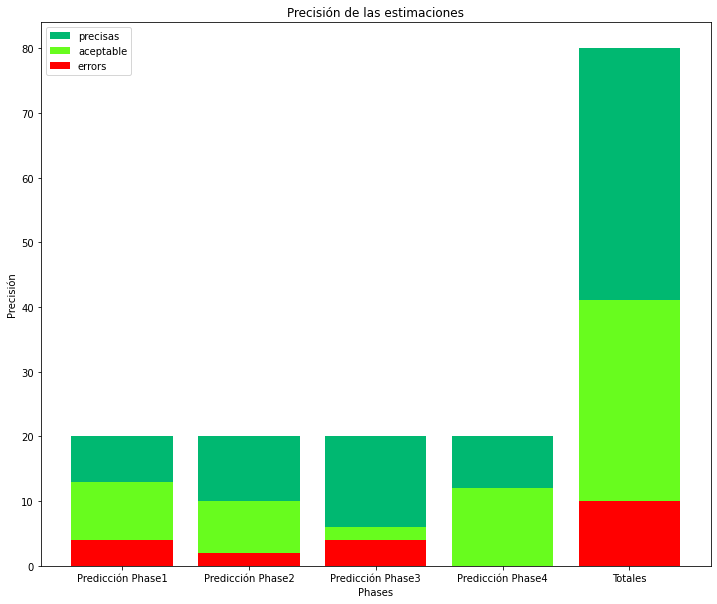

<Figure size 1080x1080 with 0 Axes>

In [14]:
phases = ['Recopilación', 'Disneo', 'Implantación', 'Soporte', 'Totales']
precisas = df_analysis_results['estimaciones_precisa'].values
aceptable = df_analysis_results['ofertas_aceptable'].values
errors = df_analysis_results['ofertas_no_aceptable'].values

pos = np.arange(len(phases))

plt.bar(pos, precisas, width=0.8, label='precisas', color='#00b871', bottom=aceptable+errors)
plt.bar(pos, aceptable, width=0.8, label='aceptable', color='#68fc1e', bottom=errors)
plt.bar(pos, errors, width=0.8, label='errors', color='red')

plt.xticks(pos, phases)
plt.ylabel("Precisión")
plt.xlabel("Phases")
plt.legend(loc="upper left")
plt.title("Precisión de las estimaciones")

# set the figure size
plt.figure(figsize=(15,15))
plt.rcParams["figure.figsize"] = [12,10]
plt.show()

## Prediccion EndPoint / Invocación Ad-Hoc

### Definición de oferta y invocación de predicción ad-hoc

In [12]:
##################################
#        OFFER DETAILS           #
##################################

offer = {
  "greenfield": 1,          # 1 == TRUE, 0 == FALSE
  "vpc": 0.5,               # 0 == 0 vpc, 0.5 == 1 vpc, 1 == 2 vpc
  "subnets": 0.75,          # 0 == 0 subnets, 0.25 == 1 subnets, 0.5 == 2 subnets, 0.75 == 3 subnets, 1 == 4 subnets
  "connectivity": 1,        # 1 == TRUE, 0 == FALSE 
  "peerings": 0,            # 1 == TRUE, 0 == FALSE 
  "directoryservice": 0,    # 1 == TRUE, 0 == FALSE
  "otherservices": 0.4,     # 0 == 0 otherservices, 0.2 == 1 otherservices, 0.4 == 2 otherservices, 0.6 == 3 otherservices, 0.8 == 4 otherservices, 1 == 5 otherservices
  "advsecurity": 0,         # 1 == TRUE, 0 == FALSE
  "advlogging": 0,          # 1 == TRUE, 0 == FALSE
  "advmonitoring": 0,       # 1 == TRUE, 0 == FALSE
  "advbackup": 0,           # 1 == TRUE, 0 == FALSE
  "vms": 0.5,               # 0 == 0 vms, 0.1 == 1 vms, 0.2 == 2 vms, 0.3 == 3 vms .... 0.8 == 8 vms, 0.9 == 9 vms, 1 == 10 vms
  "buckets": 0.5,           # 0 == 0 buckets, 0.5 == 1 buckets, 1 == 2 buckets
  "databases": 0.5,         # 0 == 0 BBDD, 0.5 == 1 BBDD, 1 == 2 BBDD
  "elb": 1,                 # 1 == TRUE, 0 == FALSE 
  "autoscripts": 0,         # 1 == TRUE, 0 == FALSE 
  "administered": 0         # 1 == TRUE, 0 == FALSE
}

##################################
#      OFFER DETAILS END         #
##################################


##################################
# HERE BE DRAGONS!!! 
# Modify the code below 
# at your own risk
##################################

# Order the index of the columns as strict ordering is required for prediction

# Phase 1 column order
colOrderPhase1 = [
  'greenfield', 
  'vpc', 
  'subnets', 
  'connectivity', 
  'peerings', 
  'directoryservice', 
  'otherservices', 
  'advsecurity', 
  'advlogging', 
  'advmonitoring', 
  'advbackup', 
  'vms', 
  'buckets', 
  'databases', 
  'elb', 
  'autoscripts', 
  'administered'
]

# Phase 2 column order
colOrderPhase2 = colOrderPhase1.copy()
colOrderPhase2.append('phase1prediction')     

# Phase 3 column order
colOrderPhase3 = colOrderPhase2.copy()
colOrderPhase3.append('phase2prediction')

# Phase 4 column order
colOrderPhase4 = colOrderPhase3.copy()
colOrderPhase4.append('phase3prediction')  

predicition_result = []


def make_phase_predictions(phase_number, phase_name, offer_details, scaler_max):
    linear_regression_ad_hoc = load("models-saved/linearlearner/phase_{}_model.model".format(phase_number))
    phase_prediction = linear_regression_ad_hoc.predict(offer_details)
    prediction_scaled = get_standard_value(scaler_max, phase_prediction[0], phase_number)
    predict_result = [phase_number, phase_name, prediction_scaled]
    predicition_result.append(predict_result)
    return prediction_scaled


# phase 1 predicition
pd_offer = pd.json_normalize(offer)
offer_frame = pd_offer.reindex(columns=colOrderPhase1)   
phase1_predicition = make_phase_predictions(1, "Recopilacion", offer_frame, train_test_phase1_scaler.data_max_)
phase1_predicition_scaled = phase1_predicition / train_test_phase1_scaler.data_max_

# phase 2 predicition
offer['phase1prediction'] = phase1_predicition_scaled
pd_offer = pd.json_normalize(offer)
offer_frame = pd_offer.reindex(columns=colOrderPhase2) 
phase2_predicition = make_phase_predictions(2, "Diseno", offer_frame, train_test_phase2_scaler.data_max_)
phase2_predicition_scaled = phase2_predicition / train_test_phase2_scaler.data_max_

# phase 3 predicition
offer['phase2prediction'] = phase2_predicition_scaled
pd_offer = pd.json_normalize(offer)
offer_frame = pd_offer.reindex(columns=colOrderPhase3)   
phase3_predicition = make_phase_predictions(3, "Implantacion", offer_frame, train_test_phase3_scaler.data_max_)
phase3_predicition_scaled = phase3_predicition / train_test_phase3_scaler.data_max_

# phase 4 predicition
offer['phase3prediction'] = phase3_predicition_scaled
pd_offer = pd.json_normalize(offer)
offer_frame = pd_offer.reindex(columns=colOrderPhase4) 
phase4_predicition = make_phase_predictions(4, "Soporte", offer_frame, train_test_phase4_scaler.data_max_)
phase4_predicition_scaled = phase4_predicition / train_test_phase4_scaler.data_max_

print("Detalles de la oferta:\n")
offer['phase1prediction'] = predicition_result[0][2]
offer['phase2prediction'] = predicition_result[1][2]
offer['phase3prediction'] = predicition_result[2][2]
offer['phase4prediction'] = predicition_result[3][2]
print(json.dumps(offer, indent=4, sort_keys=True))

print("\nPrediccion:\n")
table = PrettyTable(['# Fase','Fase','Jornadas'])
table.align["# Fase"] = "c"
table.align["Fase"] = "l"
table.align["Jornadas"] = "c"
for row in predicition_result:
    table.add_row(row)

table.add_row([5, 'Total', (phase1_predicition + phase2_predicition + phase3_predicition + phase4_predicition)])

print(table)

Detalles de la oferta:

{
    "administered": 0,
    "advbackup": 0,
    "advlogging": 0,
    "advmonitoring": 0,
    "advsecurity": 0,
    "autoscripts": 0,
    "buckets": 0.5,
    "connectivity": 1,
    "databases": 0.5,
    "directoryservice": 0,
    "elb": 1,
    "greenfield": 1,
    "otherservices": 0.4,
    "peerings": 0,
    "phase1prediction": 1.5,
    "phase2prediction": 2.5,
    "phase3prediction": 2.25,
    "phase4prediction": 1.25,
    "subnets": 0.75,
    "vms": 0.5,
    "vpc": 0.5
}

Prediccion:

+--------+--------------+----------+
| # Fase | Fase         | Jornadas |
+--------+--------------+----------+
|   1    | Recopilacion |   1.5    |
|   2    | Diseno       |   2.5    |
|   3    | Implantacion |   2.25   |
|   4    | Soporte      |   1.25   |
|   5    | Total        |   7.5    |
+--------+--------------+----------+


## Información de max phase scaler values

In [13]:
print(f"phase 1 max scaler: {train_test_phase1_scaler.data_max_}")
print(f"phase 2 max scaler: {train_test_phase2_scaler.data_max_}")
print(f"phase 3 max scaler: {train_test_phase3_scaler.data_max_}")
print(f"phase 4 max scaler: {train_test_phase4_scaler.data_max_}")

phase 1 max scaler: [7.]
phase 2 max scaler: [8.]
phase 3 max scaler: [8.]
phase 4 max scaler: [4.25]
